## Setup

Import necessary modules and dependencies.

In [1]:
!pip install seaborn
!pip install opencv-python
!pip install soundfile
!pip install keras
!pip install -q tensorflow-io
!pip install pydub

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import soundfile as sf
import shutil
import soundfile as sf
import subprocess

import tensorflow as tf
import tensorflow_io as tfio
import keras

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
import datetime
import contextlib
import wave

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from pydub import AudioSegment



In [3]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Get audio dataset

We download from google audioset (http://research.google.com/audioset/) the following audio datasets:
Gunshot_gunfire
cup_gun
machine_gun
fusillade
screaming
yell
boom
explosion
fireworks
firecracker
civil_defense_siren

Similar labels have joined so the final labels are: Screaming, Explosion, Fireworks, Gunshot_gunfire, Civil_defense_siren and Music

The folder structure consists of a folder for each label

In [4]:
audio_path = 'Dataset/Train_Data'
data_dir= pathlib.Path(audio_path)

### the commands will hold the labels and we will use it later
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != '.ipynb_checkpoints']
print('Commands:', commands)


Commands: ['Screaming' 'Explosion' 'Fireworks' 'Gunshot_gunfire'
 'Civil_defense_siren' 'Music']


In [5]:
# Print number of file in each label (directory)

for command in commands:
    path, dirs, files = next(os.walk(audio_path+'/'+command))
    print(command +": " + str(len(files)))
    

Screaming: 1458
Explosion: 2376
Fireworks: 2081
Gunshot_gunfire: 2034
Civil_defense_siren: 1660
Music: 1999


#### Extract the audio files into a list and shuffle it

In [6]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)

Number of total examples: 11608


## Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.

In [7]:
# Split to train, validation and test groups

file_count = len(filenames)

train_files = filenames[:int(file_count*0.7)]
val_files = filenames[int(file_count*0.7) : int(file_count*0.7 + file_count*0.15)]
test_files = filenames[int(-file_count*0.15):]

print('file count', file_count)
print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

file count 11608
Training set size 8125
Validation set size 1741
Test set size 1741


#### This following 2 functions are for moving not stanard files to another folder
for example files with 6 different audio channels (expected 1 or 2 channels of Mono or Stereo)

In [8]:
def getFileProperties(file_path, file):
    ob = sf.SoundFile(file_path)
    if (ob.samplerate != 22050 or ob.channels > 2 or ob.channels <1 or ob.subtype != 'PCM_16'):
        print(file_path)
        print('Sample rate: {}'.format(ob.samplerate))
        print('Channels: {}'.format(ob.channels))
        print('Subtype: {}'.format(ob.subtype))
        shutil.move(file_path, 'Dataset/6Channels/'+file)

In [10]:
for subdirectory in os.listdir(audio_path+'/'):
    print(subdirectory)
    if(subdirectory != '.ipynb_checkpoints'):
        for directory, subdirectories, files in os.walk(os.path.join(audio_path+'/',subdirectory)):   
            for file in files:
                fullPath = os.path.join(directory, file)
                getFileProperties(fullPath, file)

Screaming
Explosion
Fireworks
Gunshot_gunfire
Civil_defense_siren
.ipynb_checkpoints
Music


## Reading audio files and their labels
The audio file will initially be read as a binary file, which we want to convert into a numerical tensor.
The label for each WAV file is its parent directory.

In [11]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1,) # converted to mono channgle
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] 

In [12]:
# Take the filename of the WAV file and return a tuple containing the audio and labels for supervised training.

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    print(label)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [13]:
AUTOTUNE = tf.data.AUTOTUNE # For better performance, which will prompt the tf.data runtime to tune the value dynamically at runtime
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Tensor("strided_slice:0", shape=(), dtype=string)


Examine a few audio waveforms with their corresponding labels

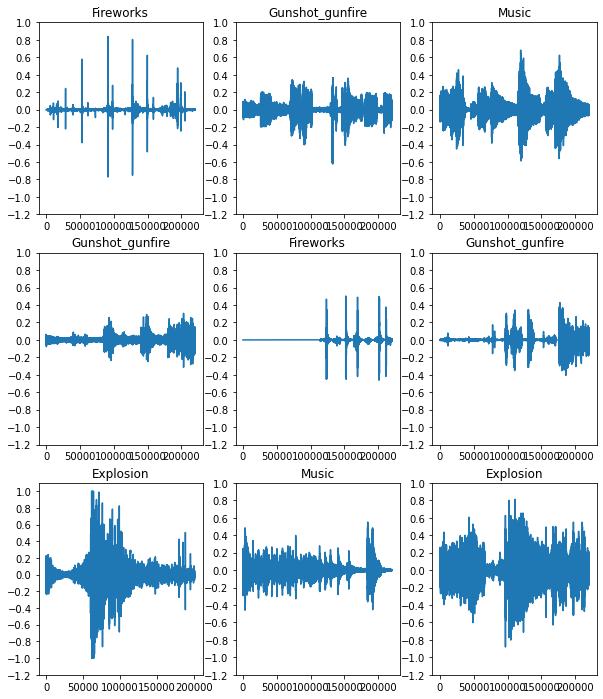

In [14]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))


for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

## Spectrogram

Convert waveform to spectrogram which show the frequency changes over time and can be represented as a 2D image.
This can be done by applying STFT (short-time Fourier transform) to convert the audio into time frequency domain.

We also want the waveforms to have the same length, so that when we convert it to a spectrogram image, the results will have similar dimensions. We do this by zero padding the audio clips that are shorter than the longest one in the dataset (about 10 seconds)

In [15]:
def get_spectrogram(waveform):
    
    # Padding for files with less than 250000 samples (sample for 10 second)
    zero_padding = tf.zeros([250000] - tf.shape(waveform), dtype=tf.float32) 

    # Concatenate audio with padding so that all audio clips will be of the 
    # same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

    spectrogram = tf.abs(spectrogram)    
    return spectrogram

##### One example from the datasets
The waveform, the spectrogram and the actual audio of one example from the dataset.

In [16]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=22050))

Label: Fireworks
Waveform shape: (220500,)
Spectrogram shape: (1952, 129)
Audio playback


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


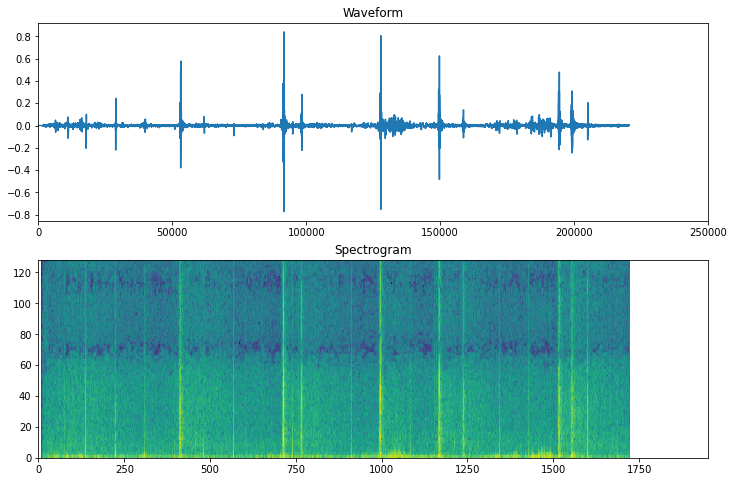

In [17]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    X = range(1952)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 250000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [18]:
# Transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == commands)
    one_hot_label = tf.one_hot(label_id, len(commands))
    print(one_hot_label)
    print(label)
    return spectrogram, one_hot_label
  
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

Tensor("one_hot:0", shape=(6,), dtype=float32)
Tensor("args_1:0", shape=(), dtype=string)


Examine the spectrogram images for different samples of the dataset.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


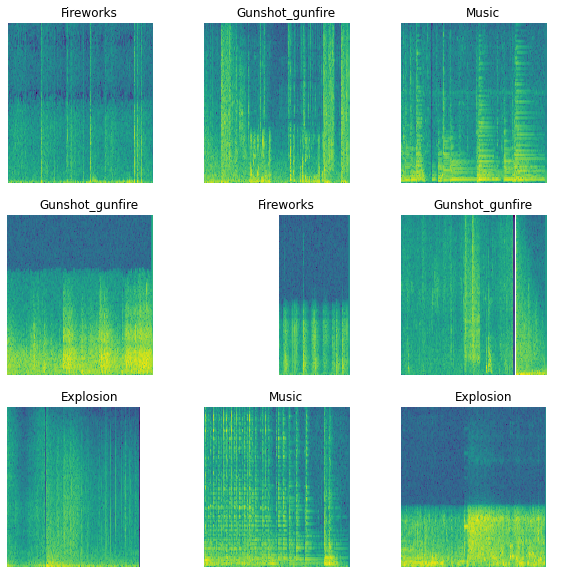

In [19]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(commands[np.argmax(label_id)])
    ax.axis('off')

plt.show()

## Build and train the model


In [20]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
    return output_ds

# Repeat the training set preprocessing on the validation and test sets also
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Tensor("strided_slice:0", shape=(), dtype=string)
Tensor("one_hot:0", shape=(6,), dtype=float32)
Tensor("args_1:0", shape=(), dtype=string)
Tensor("strided_slice:0", shape=(), dtype=string)
Tensor("one_hot:0", shape=(6,), dtype=float32)
Tensor("args_1:0", shape=(), dtype=string)


Batch the training and validation sets for model training.

In [21]:
batch_size = 20 # Tested with 10, 20 and 50
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [24]:
# Add dataset cache() and prefetch() operations to reduce read latency while training the model.
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

# Get input shape of spectrogram
for spectrogram, label in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
    print(spectrogram.shape)
    print('label:', label)
print('Input shape:', input_shape)
num_labels = len(commands)


(1952, 129, 1)
label: tf.Tensor([0. 0. 1. 0. 0. 0.], shape=(6,), dtype=float32)
Input shape: (1952, 129, 1)


For the model, we use simple CNN (convolutional neural network), since we have transformed the audio files into spectrogram images.

In [25]:
# Building the finanl CNN model

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, input_shape=(input_shape), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))

model.add(Conv2D(filters=256, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))

model.add(GlobalAveragePooling2D())
model.add(Dense(num_labels, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1951, 128, 16)     80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 975, 64, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 975, 64, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 974, 63, 32)       2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 487, 31, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 487, 31, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 486, 30, 64)      

In [30]:
# The model was tested with Epochs number of 20, 50, 80 and 100 
# and Early stopping patience of 4, 6, 8 and 10

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

EPOCHS = 80 
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=6) 
)

Epoch 1/80
407/407 [==============================] - 102s 248ms/step - loss: 0.3054 - accuracy: 0.6070 - val_loss: 0.3214 - val_accuracy: 0.5887
Epoch 2/80
407/407 [==============================] - 101s 249ms/step - loss: 0.2854 - accuracy: 0.6381 - val_loss: 0.3124 - val_accuracy: 0.5956
Epoch 3/80
 33/407 [=>............................] - ETA: 1:28 - loss: 0.2716 - accuracy: 0.6775

KeyboardInterrupt: 

#### Show training and validation loss curves to see how your model has improved during training

In [31]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

NameError: name 'history' is not defined

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
# Save the current model to file on disk

now = datetime.datetime.now()
date_time = now.strftime("%H:%M:%S-%m-%d-%Y")

model.save('models/ep-'+ str(EPOCHS) +'-AudioModel-' +  date_time + '.h5')

## Evaluate test set performance

Run the model on the test dataset and check the performance.
(Most high percent we got was 78% of test accuracy without music label and 72% with music label)

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = np.argmax(test_labels, axis=1)

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

### Display a confusion matrix

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Manual test on an audio file
Verify the model's prediction output using an input audio file of explosion (or any other label)

Tensor("strided_slice:0", shape=(), dtype=string)
Tensor("one_hot:0", shape=(6,), dtype=float32)
Tensor("args_1:0", shape=(), dtype=string)


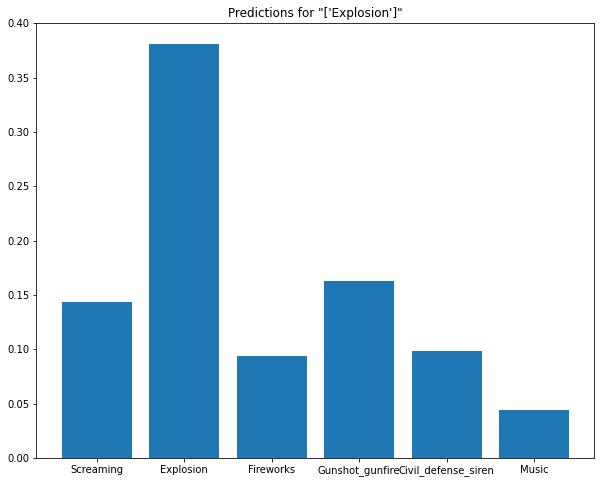

In [37]:
# Load the saved model
model = keras.models.load_model('models/ep-80-AudioModel-08:55:04-05-26-2021.h5')

sample_file = 'Dataset/Testing/Explosion/Ezmqd42xLyA.wav'
sample_ds = preprocess_dataset([str(sample_file)])

plt.figure(figsize=(10, 8))

for spectrogram, label in sample_ds.batch(1):
    prediction = model.predict(spectrogram)
    plt.bar(commands, prediction[0])
    plt.title(f'Predictions for "{commands[np.argmax(label, axis=1)]}"')
    plt.show()

# Predict over youtube audio file

## Splitting long audio file from youtube

Download sample from Youtube by id, convert it to wav format, and cut it to the first 60 seconds

In [38]:
!youtubeId='Apwf_rcT3hQ' && youtube-dl https://www.youtube.com/watch?v=${youtubeId} --quiet --extract-audio --audio-format wav --output "${youtubeId}.wav" && mv ${youtubeId}.wav "Dataset/Testing/${youtubeId}.wav" && ffmpeg -loglevel quiet -i "Dataset/Testing/${youtubeId}.wav" -ar 22050 -ss "0" -to "60" "./Dataset/Testing/${youtubeId}_out.wav"

File './Dataset/Testing/Apwf_rcT3hQ_out.wav' already exists. Overwrite ? [y/N] ^C


Splitting the wav file to small parts

In [39]:
second = 1000 # Works in milliseconds
time_to_split = 5 * second
t1 = 0 * second 
t2 = time_to_split * second


# Split the file to 5 seconds parts
duration = 0
fileid ='Apwf_rcT3hQ'
fname = 'Dataset/Testing/'+fileid+'_out.wav'
audioFile = AudioSegment.from_wav(fname)

newpath = r'Dataset/WorkingDirectory/'+fileid
if not os.path.exists(newpath):
    os.makedirs(newpath)
    
with contextlib.closing(wave.open(fname,'r')) as f:
    frames = f.getnframes()
    rate = f.getframerate()
    duration = frames / float(rate)
    print(duration)
for i in range(int(duration/5)):
    start_time = i * time_to_split
    end_time = start_time + time_to_split
    print(i+1)
    newAudio = audioFile[start_time:end_time]
    newAudio.export(newpath+'/'+str(start_time/1000)+'-'+str(end_time/1000)+'.wav', format="wav") #Exports to a wav file in the current path.

60.0
1
2
3
4
5
6
7
8
9
10
11
12


Send each part to model prediction

['Screaming' 'Explosion' 'Fireworks' 'Gunshot_gunfire'
 'Civil_defense_siren' 'Music']
Dataset/WorkingDirectory/Apwf_rcT3hQ/40.0-45.0.wav
Tensor("strided_slice:0", shape=(), dtype=string)
Tensor("one_hot:0", shape=(6,), dtype=float32)
Tensor("args_1:0", shape=(), dtype=string)
[[0.14819786 0.2633306  0.36011457 0.33979872 0.06602981 0.17497012]]


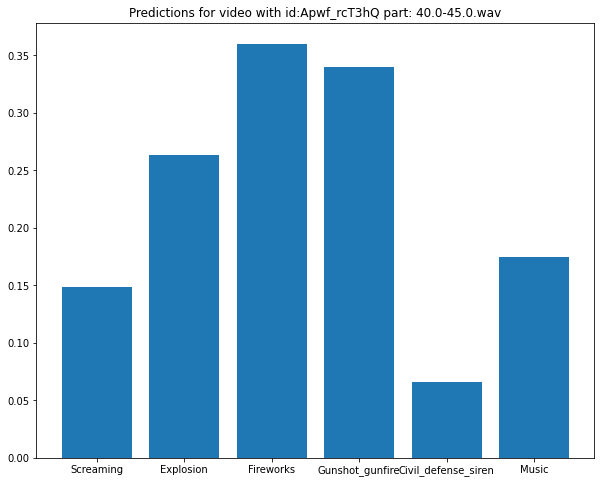

Dataset/WorkingDirectory/Apwf_rcT3hQ/25.0-30.0.wav
Tensor("strided_slice:0", shape=(), dtype=string)
Tensor("one_hot:0", shape=(6,), dtype=float32)
Tensor("args_1:0", shape=(), dtype=string)
[[0.26287335 0.36447206 0.15111254 0.27079496 0.04837964 0.37055558]]


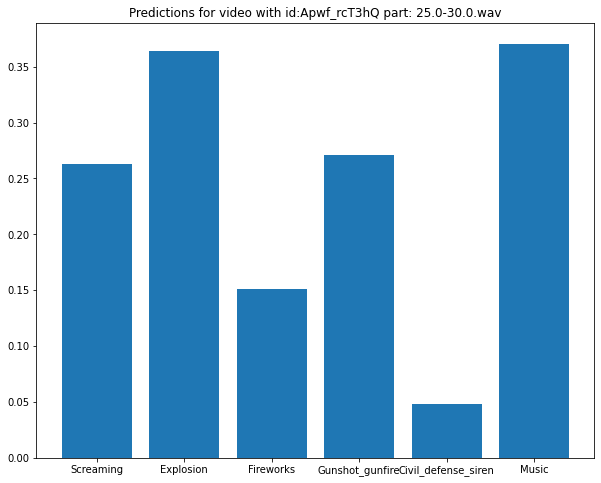

Dataset/WorkingDirectory/Apwf_rcT3hQ/10.0-15.0.wav
Tensor("strided_slice:0", shape=(), dtype=string)
Tensor("one_hot:0", shape=(6,), dtype=float32)
Tensor("args_1:0", shape=(), dtype=string)
[[0.25709245 0.3357369  0.14796177 0.24333824 0.06650051 0.37202808]]


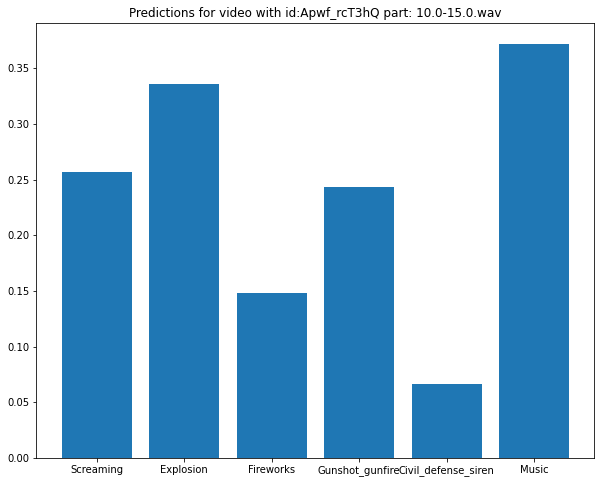

Dataset/WorkingDirectory/Apwf_rcT3hQ/20.0-25.0.wav
Tensor("strided_slice:0", shape=(), dtype=string)
Tensor("one_hot:0", shape=(6,), dtype=float32)
Tensor("args_1:0", shape=(), dtype=string)
[[0.26898563 0.3704279  0.17068917 0.31410939 0.05684165 0.29072404]]


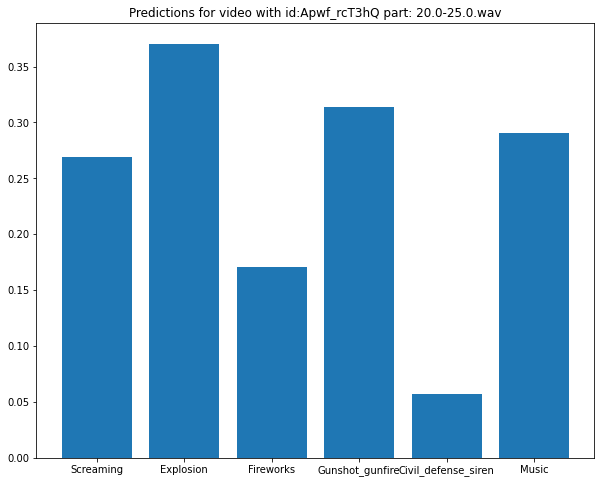

Dataset/WorkingDirectory/Apwf_rcT3hQ/45.0-50.0.wav
Tensor("strided_slice:0", shape=(), dtype=string)
Tensor("one_hot:0", shape=(6,), dtype=float32)
Tensor("args_1:0", shape=(), dtype=string)
[[0.20104533 0.27026606 0.15521221 0.31475908 0.04917067 0.27852756]]


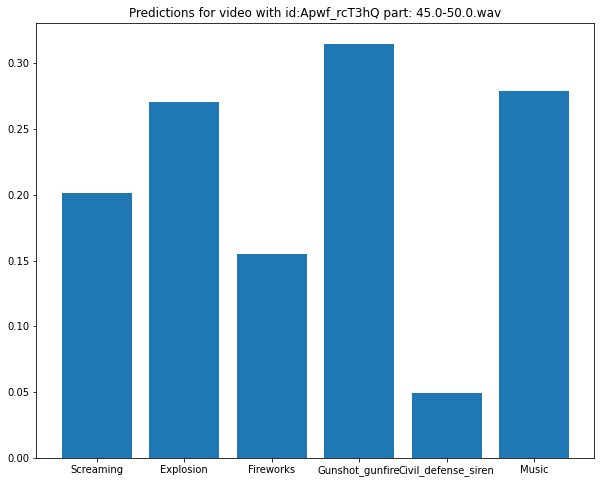

Dataset/WorkingDirectory/Apwf_rcT3hQ/30.0-35.0.wav
Tensor("strided_slice:0", shape=(), dtype=string)
Tensor("one_hot:0", shape=(6,), dtype=float32)
Tensor("args_1:0", shape=(), dtype=string)
[[0.26765573 0.32818675 0.14472084 0.26631656 0.04695598 0.36407346]]


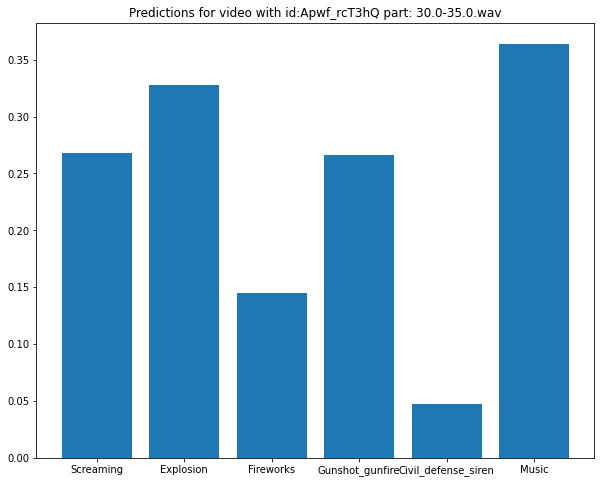

Dataset/WorkingDirectory/Apwf_rcT3hQ/0.0-5.0.wav
Tensor("strided_slice:0", shape=(), dtype=string)
Tensor("one_hot:0", shape=(6,), dtype=float32)
Tensor("args_1:0", shape=(), dtype=string)
[[0.32752815 0.36109996 0.14615896 0.26274052 0.03528524 0.34475052]]


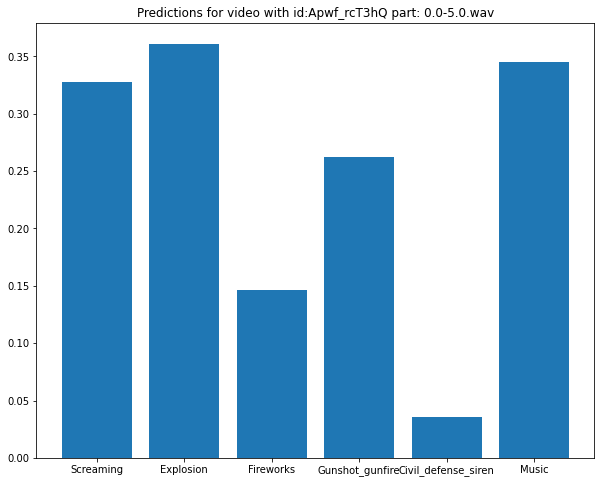

Dataset/WorkingDirectory/Apwf_rcT3hQ/15.0-20.0.wav
Tensor("strided_slice:0", shape=(), dtype=string)
Tensor("one_hot:0", shape=(6,), dtype=float32)
Tensor("args_1:0", shape=(), dtype=string)
[[0.23324889 0.3083651  0.13544393 0.24016248 0.05354926 0.41443452]]


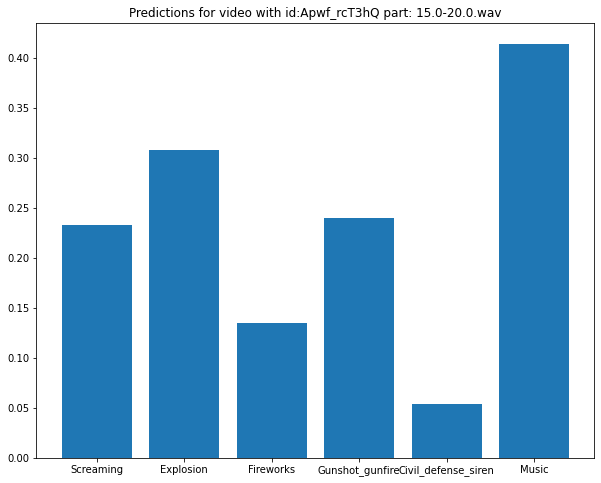

Dataset/WorkingDirectory/Apwf_rcT3hQ/55.0-60.0.wav
Tensor("strided_slice:0", shape=(), dtype=string)
Tensor("one_hot:0", shape=(6,), dtype=float32)
Tensor("args_1:0", shape=(), dtype=string)
[[0.18540466 0.3286496  0.24900831 0.42420357 0.07141595 0.1499415 ]]


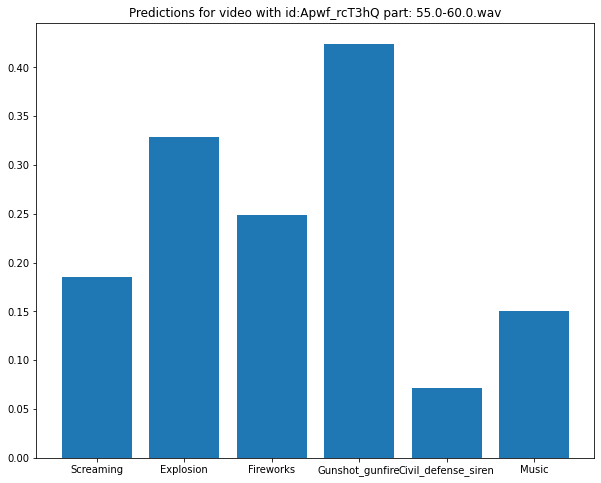

Dataset/WorkingDirectory/Apwf_rcT3hQ/50.0-55.0.wav
Tensor("strided_slice:0", shape=(), dtype=string)
Tensor("one_hot:0", shape=(6,), dtype=float32)
Tensor("args_1:0", shape=(), dtype=string)
[[0.20969528 0.32850525 0.17164105 0.35158893 0.09179389 0.28916612]]


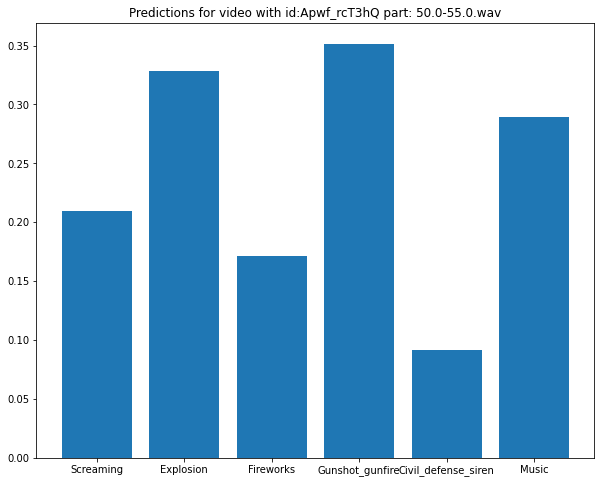

Dataset/WorkingDirectory/Apwf_rcT3hQ/5.0-10.0.wav
Tensor("strided_slice:0", shape=(), dtype=string)
Tensor("one_hot:0", shape=(6,), dtype=float32)
Tensor("args_1:0", shape=(), dtype=string)
[[0.30844572 0.40116304 0.18561046 0.27987304 0.04237041 0.2808598 ]]


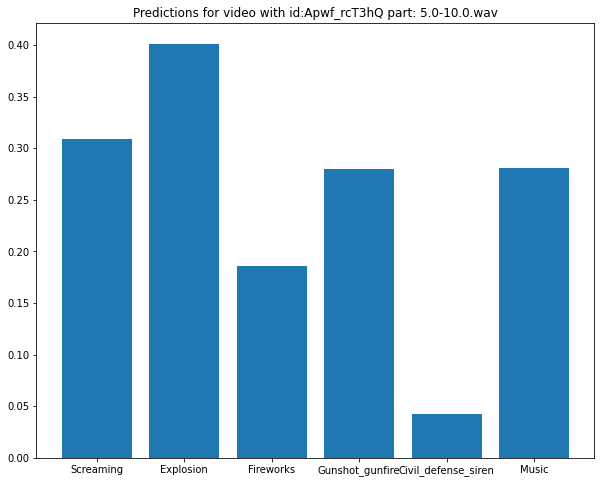

Dataset/WorkingDirectory/Apwf_rcT3hQ/35.0-40.0.wav
Tensor("strided_slice:0", shape=(), dtype=string)
Tensor("one_hot:0", shape=(6,), dtype=float32)
Tensor("args_1:0", shape=(), dtype=string)
[[0.27654117 0.3178478  0.13421646 0.251629   0.05720196 0.3607545 ]]


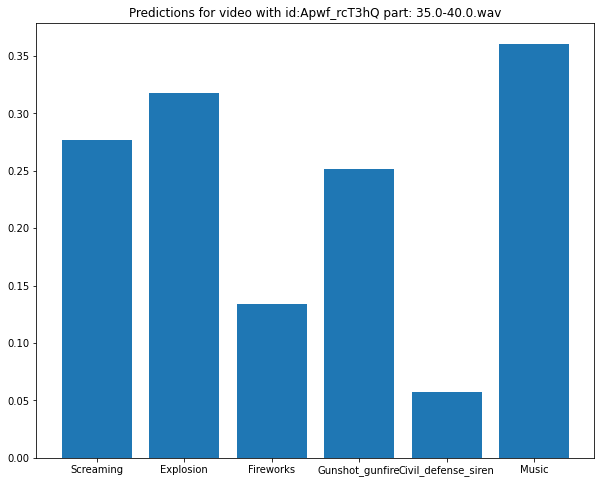

{'labels': array(['Screaming', 'Explosion', 'Fireworks', 'Gunshot_gunfire',
       'Civil_defense_siren', 'Music'], dtype='<U19'), '40.0-45.0.wav': array([0.14819786, 0.2633306 , 0.36011457, 0.33979872, 0.06602981,
       0.17497012], dtype=float32), '25.0-30.0.wav': array([0.26287335, 0.36447206, 0.15111254, 0.27079496, 0.04837964,
       0.37055558], dtype=float32), '10.0-15.0.wav': array([0.25709245, 0.3357369 , 0.14796177, 0.24333824, 0.06650051,
       0.37202808], dtype=float32), '20.0-25.0.wav': array([0.26898563, 0.3704279 , 0.17068917, 0.31410939, 0.05684165,
       0.29072404], dtype=float32), '45.0-50.0.wav': array([0.20104533, 0.27026606, 0.15521221, 0.31475908, 0.04917067,
       0.27852756], dtype=float32), '30.0-35.0.wav': array([0.26765573, 0.32818675, 0.14472084, 0.26631656, 0.04695598,
       0.36407346], dtype=float32), '0.0-5.0.wav': array([0.32752815, 0.36109996, 0.14615896, 0.26274052, 0.03528524,
       0.34475052], dtype=float32), '15.0-20.0.wav': array([0.23324

In [41]:
data_dir = pathlib.Path('Dataset/WorkingDirectory/'+fileid)

print(commands)

results = {}
results['labels'] = commands

# For each file part 
for filename in os.listdir(data_dir):
    if(filename != '.ipynb_checkpoints' and ('wav' in filename)):
        fullFileName = os.path.join(data_dir, filename)
        print(fullFileName)
        sample_ds = preprocess_dataset([fullFileName])

        plt.figure(figsize=(10, 8))

        for spectrogram, label in sample_ds.batch(1):
            
            # Predict current part
            prediction = model.predict(spectrogram)
            print(prediction)
            
            # Show Bar graph of prediction
            plt.bar(commands, prediction[0])
            plt.title('Predictions for video with id:'+fileid +' part: '+filename)
            plt.show()
            results[filename] = prediction[0]
        
print (results)

# Util functions

In [ ]:
# For fusion final model - convert Mp4 to Wav

fName = 'The Weeknd - Save Your Tears Live.mp4'
src = 'Dataset/mp4Before/' + fName
dest = 'Dataset/WavAfter/' + fName

command = "ffmpeg -i '" + src + "' -ac 2 -f wav '" + dest + "'"
print(command)
subprocess.call(command, shell=True)